<a href="https://colab.research.google.com/github/Siyu-Miao/AI-project/blob/main/AI_Project(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # !pip install torch
# !pip install --upgrade pandas
# !pip install --upgrade --no-cache-dir pandas

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
# import os
# print(os.listdir('/content/drive/My Drive/NYU-Master'))
# # 再逐层查找 'NYU-Master' -> '25-Spring-NYU' ...


['NYU 资料', '2023 Fall-NYU', '2024Spring-NYU', '日常找工作啦啦啦', 'Mia0307 Data.pdf', 'CV Miao-English.pdf', 'MiaFin-0308.pdf', 'Mia1009.gdoc', '2025-Spring-NYU']


In [129]:
import pandas as pd

base_path = '/content/drive/My Drive/NYU-Master/2025-Spring-NYU/AI-Project/Dataset/'

#follow City D
cityD_df = pd.read_csv(base_path + 'cityD-dataset.csv')
poi_data_cityD_df = pd.read_csv(base_path + 'POIdata_cityD.csv')
poi_categories_df = pd.read_csv(base_path + 'POI_datacategories.csv')

# Show a preview of each dataset
cityD_preview = cityD_df.head()
poi_categories_preview = poi_categories_df.head()
poi_data_cityD_preview = poi_data_cityD_df.head()

cityD_df.columns, poi_categories_df.columns, poi_data_cityD_df.columns


(Index(['uid', 'd', 't', 'x', 'y'], dtype='object'),
 Index(['Food'], dtype='object'),
 Index(['x', 'y', 'category', 'POI_count'], dtype='object'))

每 10 个连续坐标点预测第 11 个点的位置（归一化的 x, y 坐标）；

输出模型训练输入 X 和预测目标 y。



In [32]:

unique_users = cityD_df['uid'].nunique()

# 按用户分组，统计每个用户的移动轨迹长度（天数 * 时间点数）
trajectory_lengths = cityD_df.groupby('uid').size().describe()


missing_values = cityD_df.isnull().sum()

unique_users, trajectory_lengths, missing_values


(6000,
 count    6000.000000
 mean     1403.022500
 std       548.569411
 min       200.000000
 25%      1042.750000
 50%      1362.000000
 75%      1751.000000
 max      3435.000000
 dtype: float64,
 uid    0
 d      0
 t      0
 x      0
 y      0
 dtype: int64)

In [35]:
print(cityD_df[['x', 'y']].head())


     x    y
0  133  103
1  143   98
2  162   99
3  149   97
4  144   98


In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
import random

# ----------------------------
# Step 1: Select active users
# ----------------------------
top_active_uids = cityD_df['uid'].value_counts().index
active_users_sample = cityD_df[cityD_df['uid'].isin(top_active_uids)].copy()

# Sort
active_users_sample = active_users_sample.sort_values(by=['uid', 'd', 't'])

# ----------------------------
# Step 2: Train/Val Split by Day
# ----------------------------
train_df = active_users_sample[active_users_sample['d'] <= 59].copy()
val_df   = active_users_sample[active_users_sample['d'] >= 60].copy()

# ----------------------------
# Step 3: Create sequences
# ----------------------------
def build_sequences(data, seq_len=10):
    X, y = [], []
    for uid, group in data.groupby('uid'):
        group = group.sort_values(by=['d', 't'])
        x_vals = list(group['x'])
        y_vals = list(group['y'])

        # 组合为二维序列，每个元素是 [x, y]
        coords = list(zip(x_vals, y_vals))  # shape: (N, 2)

        for i in range(len(coords) - seq_len):
            seq = coords[i:i+seq_len]       # shape: (seq_len, 2)
            target = coords[i+seq_len]      # shape: (2,)
            X.append(seq)
            y.append(target)

    return np.array(X), np.array(y)


X_train, y_train = build_sequences(train_df)
X_test, y_test   = build_sequences(val_df)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)




In [40]:
# ================================
# Add DataLoader for batch training
# ================================
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64  # 或者根据你的内存大小调整，比如32、128都行

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# ----------------------------
# Step 4: RNN Model Definition
# ----------------------------
class SimpleRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])  # last step output

# Instantiate model
model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
num_epochs = 10  # 看你想跑几轮

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}')

# ================================
# Evaluate on test set
# ================================
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
print(f'Test Loss: {test_loss/len(test_loader):.4f}')




Epoch 1, Train Loss: 191.6004
Epoch 2, Train Loss: 63.8839
Epoch 3, Train Loss: 73.6955
Epoch 4, Train Loss: 79.7791
Epoch 5, Train Loss: 87.9806
Epoch 6, Train Loss: 72.7818
Epoch 7, Train Loss: 67.5868
Epoch 8, Train Loss: 66.6797
Epoch 9, Train Loss: 73.7751
Epoch 10, Train Loss: 65.1038
Test Loss: 62.8651


In [43]:
# # ---------------------------
# # Step 6: Evaluation
# # ---------------------------

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model.to(DEVICE)

model.eval()

# Batch size for prediction
prediction_batch_size = 1024  # Adjust as needed

# Initialize an empty list to store predictions
y_pred_list = []

# Process data in batches
for i in range(0, len(X_test_tensor), prediction_batch_size):
    batch = X_test_tensor[i:i + prediction_batch_size].to(DEVICE)
    with torch.no_grad():
        batch_pred = model(batch).detach().cpu().numpy()
    y_pred_list.extend(batch_pred)

# Concatenate predictions from all batches
y_pred = np.array(y_pred_list)
y_true = y_test  # 真实标签仍是 numpy

# 计算指标
mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("\n✅ Evaluation Metrics:")
print(f" MSE  = {mse:.5f}")
print(f" RMSE = {rmse:.5f}")
print(f" MAE  = {mae:.5f}")


✅ Evaluation Metrics:
 MSE  = 62.69742
 RMSE = 7.91817
 MAE  = 4.20753


In [101]:
def build_sequences_force_all_users(data, seq_len=10):
    """
    构建带元数据的序列，确保每个 uid 至少贡献一个目标点。
    对于长度不足 seq_len 的用户，使用 padding 或重复补齐。

    返回：
        X: shape (N, seq_len, 2)
        y: shape (N, 2)
        meta: DataFrame 包含 uid, d, t, x, y
    """
    X, y, meta = [], [], []

    for uid, group in data.groupby('uid'):
        group = group.sort_values(by=['d', 't']).reset_index(drop=True)
        x_vals = list(group['x'])
        y_vals = list(group['y'])

        if len(group) >= seq_len + 1:
            for i in range(len(group) - seq_len):
                seq = list(zip(x_vals[i:i+seq_len], y_vals[i:i+seq_len]))
                target = (x_vals[i+seq_len], y_vals[i+seq_len])
                X.append(seq)
                y.append(target)
                meta.append(group.iloc[i + seq_len])
        elif len(group) >= 2:
            # 用重复第一个点补齐
            padding = [(x_vals[0], y_vals[0])] * (seq_len - len(group) + 1)
            seq = padding + list(zip(x_vals[:-1], y_vals[:-1]))
            target = (x_vals[-1], y_vals[-1])
            X.append(seq)
            y.append(target)
            meta.append(group.iloc[-1])
        else:
            # 仅1条记录：无法预测，跳过
            continue

    return np.array(X), np.array(y), pd.DataFrame(meta)


In [102]:
# X_test, y_test, meta_test = build_sequences_force_all_users(val_df, seq_len=10)
# print(len(X_test), len(y_test), len(meta_test))
# print("val_df 总行数：", len(val_df))
# print("唯一用户数：", val_df['uid'].nunique())
# print("预测中包含用户数：", meta_test['uid'].nunique())


1661629 1661629 1661629
val_df 总行数： 1721629
唯一用户数： 6000
预测中包含用户数： 6000


In [133]:
result

,uid,d,t,x,y,true_x,true_y,pred_x,pred_y
0,0,60,25,141,108,141,108,141.979477,93.175934
1,0,60,26,140,110,140,110,136.971817,108.650162
2,0,60,27,121,133,121,133,136.866196,108.162445
3,0,60,28,117,134,117,134,113.636513,137.312546
4,0,60,29,120,133,120,133,114.060127,132.925034
...,...,...,...,...,...,...,...,...,...
1661624,5999,74,37,97,121,97,121,91.165710,117.840668
1661625,5999,74,38,110,120,110,120,97.714325,120.707901
1661626,5999,74,39,111,111,111,111,109.458321,118.706886
1661627,5999,74,46,110,110,110,110,107.869591,107.935791


In [134]:
filter=cityD_df[cityD_df['d']==60]
filter.head(20)

,uid,d,t,x,y
1394,0,60,12,129,102
1395,0,60,13,143,98
1396,0,60,14,143,102
1397,0,60,15,141,106
1398,0,60,16,125,129
1399,0,60,17,116,134
1400,0,60,19,119,133
1401,0,60,20,137,123
1402,0,60,21,137,115
1403,0,60,22,143,98


In [83]:
# 模型预测
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

y_pred = []
for i in range(0, len(X_test_tensor), 1024):
    batch = X_test_tensor[i:i+1024]
    with torch.no_grad():
        batch_pred = model(batch).detach().cpu().numpy()
    y_pred.extend(batch_pred)

y_pred = np.array(y_pred)

# 合并结果
meta_test['true_x'] = y_test[:, 0]
meta_test['true_y'] = y_test[:, 1]
meta_test['pred_x'] = y_pred[:, 0]
meta_test['pred_y'] = y_pred[:, 1]

# 保存最后15天预测结果
result = meta_test[meta_test['d'] >= 60]



In [111]:
result

,uid,d,t,x,y,true_x,true_y,pred_x,pred_y
0,0,60,25,141,108,141,108,141.979477,93.175934
1,0,60,26,140,110,140,110,136.971817,108.650162
2,0,60,27,121,133,121,133,136.866196,108.162445
3,0,60,28,117,134,117,134,113.636513,137.312546
4,0,60,29,120,133,120,133,114.060127,132.925034
...,...,...,...,...,...,...,...,...,...
1661624,5999,74,37,97,121,97,121,91.165710,117.840668
1661625,5999,74,38,110,120,110,120,97.714325,120.707901
1661626,5999,74,39,111,111,111,111,109.458321,118.706886
1661627,5999,74,46,110,110,110,110,107.869591,107.935791


In [110]:
result.to_csv('/content/drive/My Drive/NYU-Master/2025-Spring-NYU/AI-Project/y_pred_last15days.csv', index=False)

<ipython-input-46-8ca6224da54a>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', 100)  # 调色盘，最多100种不同颜色


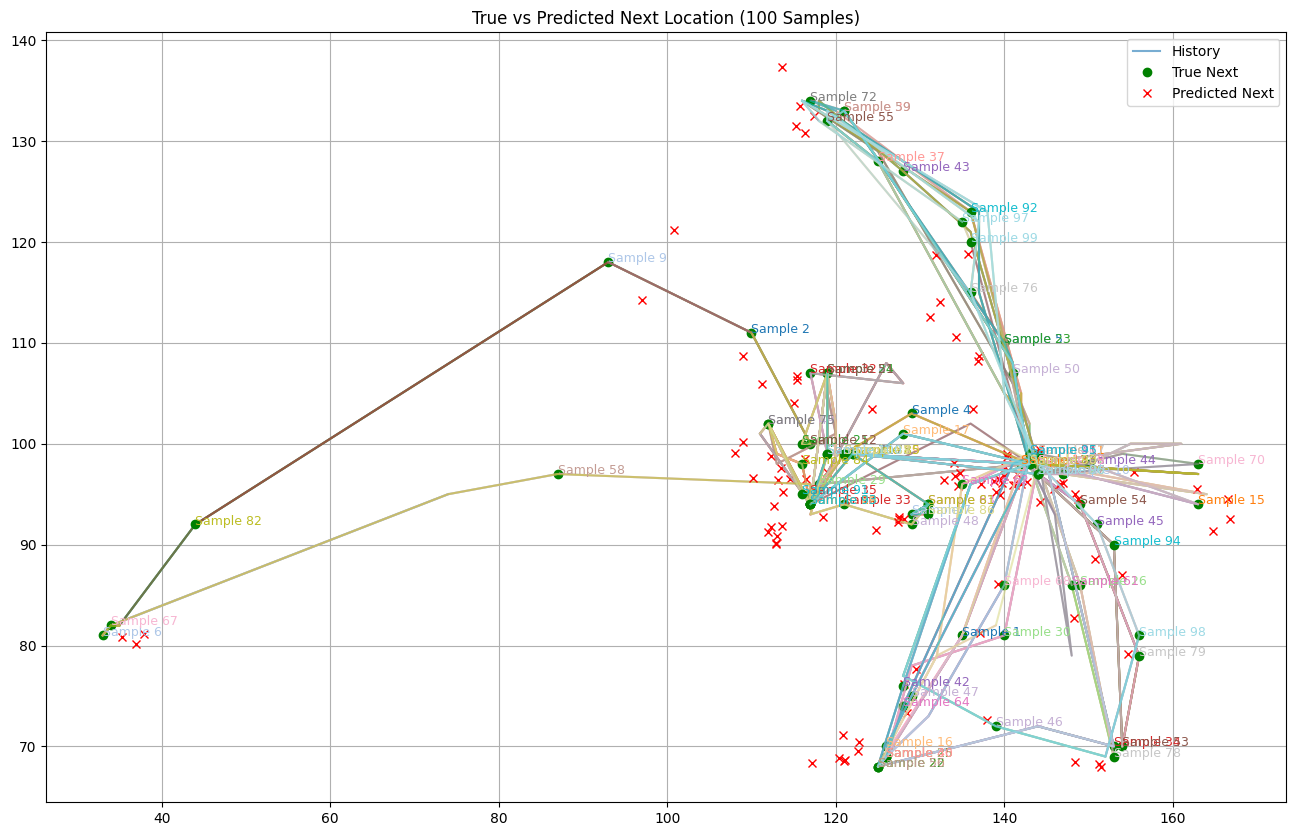

In [46]:
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm  # 用colormap来自动生成不同颜色

# ---------------------------
# Step 7: Visualization (Colorful Lines + Labels)
# ---------------------------

sample_size = min(200, len(y_test))
sampled_idx = random.sample(range(sample_size), 100)

colors = cm.get_cmap('tab20', 100)  # 调色盘，最多100种不同颜色

plt.figure(figsize=(16, 10))

for i, idx in enumerate(sampled_idx):
    history = X_test[idx]
    true_next = y_test[idx]
    pred_next = y_pred[idx]

    color = colors(i)  # 不同轨迹用不同颜色

    # 画轨迹历史（彩色线）
    plt.plot(*zip(*history), color=color, alpha=0.6)

    # 画真实下一个点（绿色圆圈）
    plt.plot(*true_next, 'go')

    # 画预测下一个点（红色叉）
    plt.plot(*pred_next, 'rx')

    # 加编号注释
    plt.text(true_next[0], true_next[1], f"Sample {i+1}", color=color, fontsize=9)

plt.title("True vs Predicted Next Location (100 Samples)")
plt.legend(["History", "True Next", "Predicted Next"])
plt.grid(True)
plt.show()


In [ ]:
from google.colab import files
import torch

# Save out your state_dict
torch.save(model.state_dict(), 'model.pth')

# This will pop up a browser download dialog
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MAE 可以更好！但需要更多时间，(修改epoch， Limit to top 100 active users, 这个数值我改成1000就run不出来，太大了，colab 自动崩溃了）